In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from src.main import get_pages, calc_document_layout
from src import sweep
import utils

pdf_path = Path('/home/jtt/Documents/datasets/wormbase/pmid18430929.pdf')
full_base_path = Path('/home/jtt/Documents/outputs/tests')

# TODO: review pmid19158391 for Syntax Warning: Bad annotation destination

In [2]:
# xpdf_folder_name = f"xpdf_{pdf_path.stem}"
# xpdf_folder_path = utils.pdf2html(
#     pdf_path.resolve(), full_base_path.resolve(), xpdf_folder_name
# )

In [3]:
xpdf_folder_path = '/home/jtt/Documents/outputs/tests/samples/xpdf_pmid19158391'
# xpdf_folder_path = Path('../tests/output/pdf2')
pages = get_pages(Path(xpdf_folder_path))

In [4]:
layout = calc_document_layout(pages)
layout

Layout(width=594, height=783, num_cols=2, row_width=239, row_height=11, content_region=Bbox(x=48, y=33, width=498, height=729, x1=546, y1=762), col_coords=[48, 306])

In [5]:
from src.draw import draw_content_region, draw_text_regions, draw_columns, draw_bboxes
from src.contours import get_potential_contours
from PIL import Image

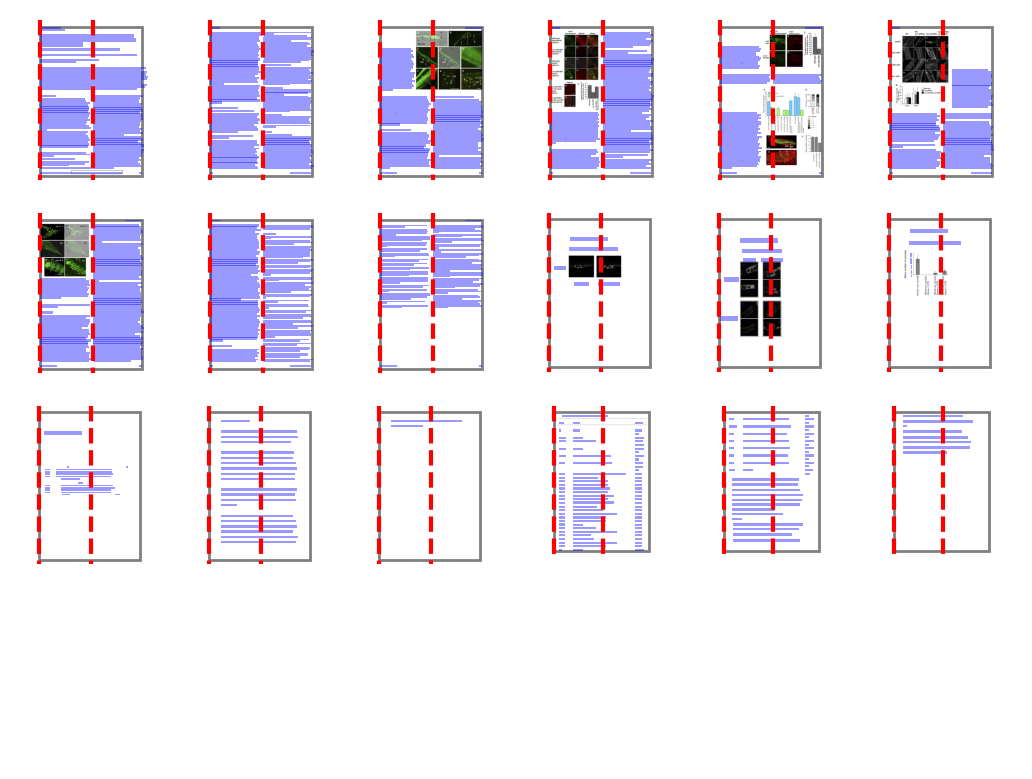

In [6]:
number_cols = 6
number_rows = int(len(pages) / number_cols) + 1
_, ax = plt.subplots(number_rows, number_cols, dpi=200)

for idx, page in enumerate(pages):
  col = idx % number_cols
  row = int(idx / number_cols) 

  page_name = page.img_name
  png_path = (Path(xpdf_folder_path) / page_name).resolve()
  page_image = Image.open(png_path)
  page_image = page_image.resize((page.width, page.height)) 

  draw_content_region(ax[row][col], layout.content_region)
  draw_text_regions(ax[row][col], page)
  draw_columns(ax[row][col], layout)
  ax[row][col].imshow(page_image)
  ax[row][col].axis('off')

for idx in range(len(pages), number_rows*number_cols):
  col = idx % number_cols
  row = int(idx / number_cols) 
  ax[row][col].axis('off')

## Try to find expand captions first

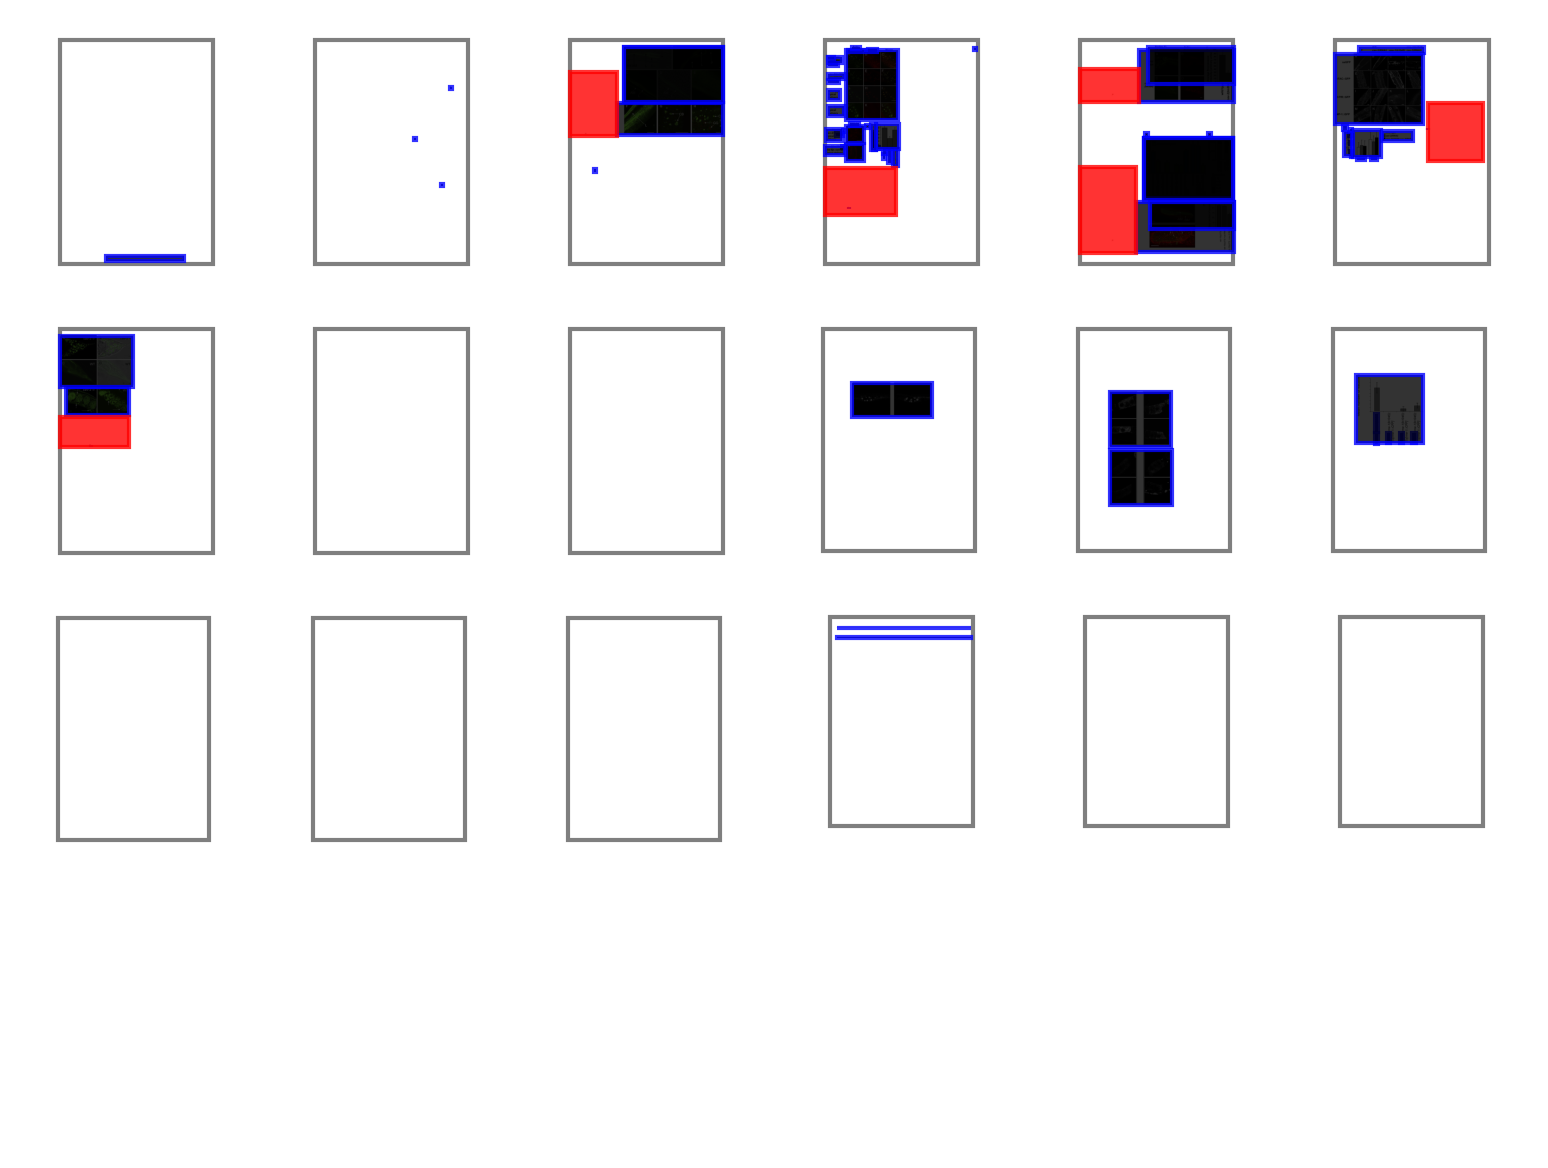

In [7]:
number_cols = 6
number_rows = int(len(pages) / number_cols) + 1
_, ax = plt.subplots(number_rows, number_cols, dpi=300)

for idx, page in enumerate(pages):
  col = idx % number_cols
  row = int(idx / number_cols) 

  page_name = page.img_name
  png_path = (Path(xpdf_folder_path) / page_name).resolve()
  page_image = Image.open(png_path)
  page_image = page_image.resize((page.width, page.height)) 

  fig_captions, table_captions = page.find_caption_boxes()
  fig_captions = [page.expand_caption(caption, layout) for caption in fig_captions]  
  candidates, cnts = get_potential_contours(xpdf_folder_path, page, layout, fig_captions)

  draw_content_region(ax[row][col], layout.content_region)
  draw_bboxes(ax[row][col], cnts, edgecolor='blue', facecolor='black', alpha=0.8)
  draw_bboxes(ax[row][col], fig_captions, edgecolor='red', facecolor='red', alpha=0.8)

  ax[row][col].imshow(page_image)
  ax[row][col].axis('off')

for idx in range(len(pages), number_rows*number_cols):
  col = idx % number_cols
  row = int(idx / number_cols) 
  ax[row][col].axis('off')

## 2. Region Detection
Use the captions for figures and tables to find potential areas in the page that
can hold a figure.

In [8]:
from src.contours import overlap_ratio_based

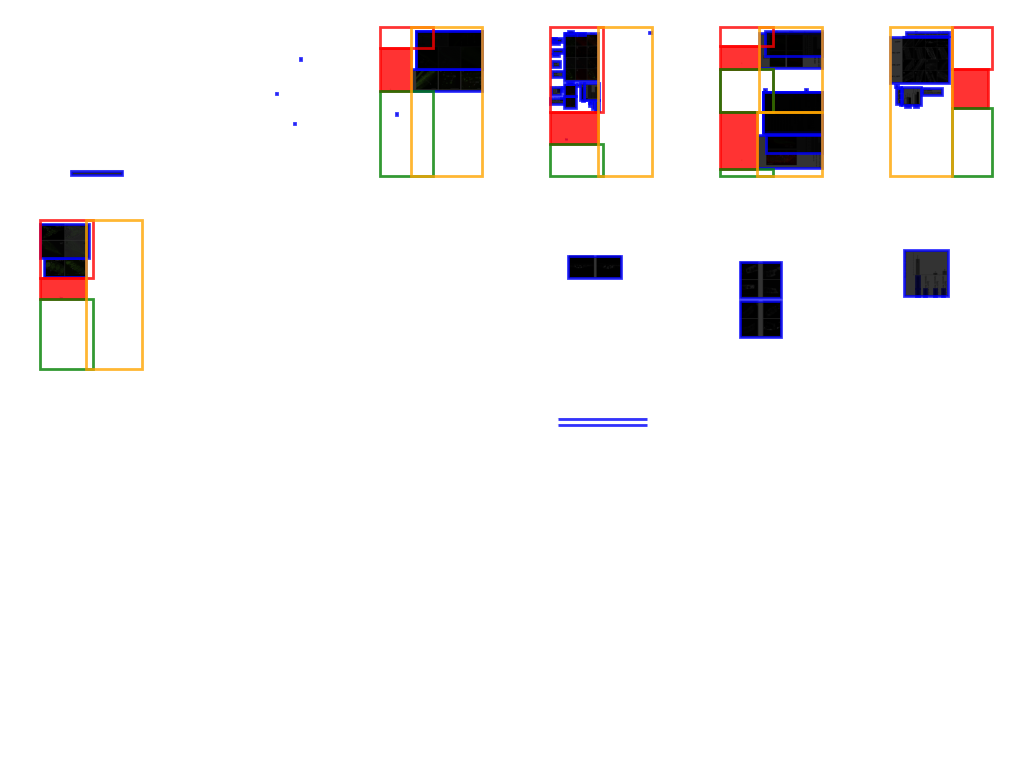

In [9]:
number_cols = 6
number_rows = int(len(pages) / number_cols) + 1
_, ax = plt.subplots(number_rows, number_cols, dpi=200)

for idx, page in enumerate(pages):
  col = idx % number_cols
  row = int(idx / number_cols) 
  page_name = page.img_name
  png_path = (Path(xpdf_folder_path) / page_name).resolve()
  page_image = Image.open(png_path)
  page_image = page_image.resize((page.width, page.height))

  fig_captions, table_captions = page.find_caption_boxes()
  fig_captions = [page.expand_caption(caption, layout) for caption in fig_captions] 

  regions_top = sweep.estimate_caption_regions_top(fig_captions, layout)
  regions_bottom = sweep.estimate_caption_regions_bottom(fig_captions, layout)
  regions_side = sweep.estimate_caption_regions_side(fig_captions, layout)

  candidates, cnts = get_potential_contours(xpdf_folder_path, page, layout, fig_captions)
  draw_bboxes(ax[row][col], cnts, edgecolor='blue', facecolor='black', alpha=0.8)
  draw_bboxes(ax[row][col], fig_captions, edgecolor='red', facecolor='red', alpha=0.8)

  top_bboxes = [el.bbox for el in regions_top]
  bottom_boxes = [el.bbox for el in regions_bottom]
  side_boxes = [el.bbox for el in regions_side]

  draw_bboxes(ax[row][col], top_bboxes, edgecolor='red', facecolor='none', alpha=0.8)
  draw_bboxes(ax[row][col], bottom_boxes, edgecolor='green', facecolor='none', alpha=0.8)
  draw_bboxes(ax[row][col], side_boxes, edgecolor='orange', facecolor='none', alpha=0.8)

  # draw_columns(ax[row][col], layout)
  ax[row][col].imshow(page_image)
  ax[row][col].axis('off')

for idx in range(len(pages), number_rows*number_cols):
  col = idx % number_cols
  row = int(idx / number_cols) 
  ax[row][col].axis('off')

In [10]:
def filter_images_by_area(page, threshold=1000):
  page.figures = [f for f in page.figures if f.bbox.width * f.bbox.height > threshold]

for page in pages:
  fig_captions, table_captions = page.find_caption_boxes()
  fig_captions = [page.expand_caption(caption, layout) for caption in fig_captions] 
  candidates, _ = get_potential_contours(xpdf_folder_path, page, layout, fig_captions)
  if len(fig_captions) > 0 and len(candidates) > 0:
    sweep.sweep_regions(page, candidates, fig_captions, table_captions, layout)
sweep.match_orphans(pages, layout)

for page in pages:
  filter_images_by_area(page)


3
Bbox(x=201, y=56, width=345, height=288, x1=546, y1=344)
4
Bbox(x=49, y=66, width=238, height=378, x1=287, y1=444)
5
5
5
6
Bbox(x=47, y=58, width=289, height=357, x1=336, y1=415)
7
Bbox(x=49, y=57, width=238, height=256, x1=287, y1=313)


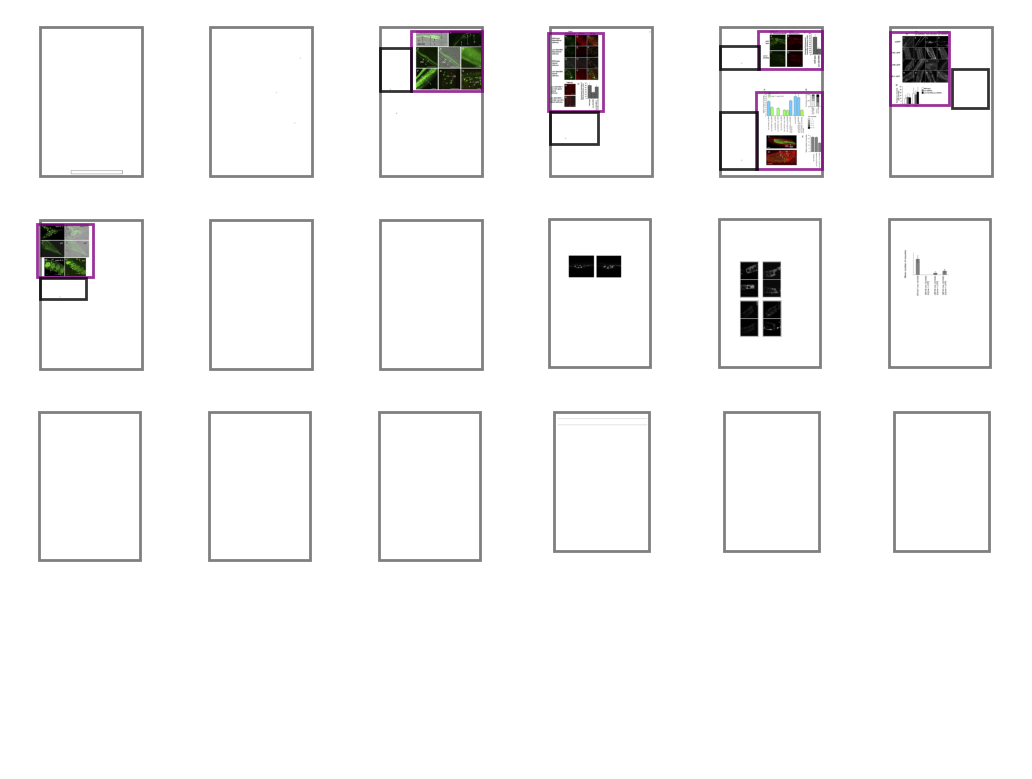

In [11]:
number_cols = 6
number_rows = int(len(pages) / number_cols) + 1
_, ax = plt.subplots(number_rows, number_cols, dpi=200)

for idx, page in enumerate(pages):
  col = idx % number_cols
  row = int(idx / number_cols) 

  page_name = page.img_name
  png_path = (Path(xpdf_folder_path) / page_name).resolve()
  page_image = Image.open(png_path)
  page_image = page_image.resize((page.width, page.height)) 

  draw_content_region(ax[row][col], layout.content_region)

  figures = [x.bbox for x in page.figures]
  captions = [x.caption for x in page.figures if x.caption is not None]
  draw_bboxes(ax[row][col], figures, 'purple', 'none', 0.8)
  draw_bboxes(ax[row][col], captions, 'black', 'none', 0.8)

  ax[row][col].imshow(page_image)
  ax[row][col].axis('off')

for idx in range(len(pages), number_rows*number_cols):
  col = idx % number_cols
  row = int(idx / number_cols) 
  ax[row][col].axis('off')

In [12]:
pages[3].figures

[Figure(bbox=Bbox(x=36.0, y=66, width=270.0, height=378, x1=306, y1=444), multicolumn=True, caption=TextBox(x=48, y=450, width=232, height=153, x1=280, y1=603, page_number=4, text='Figure 2. cav-2 mutants show defective accumulation of the lipid trafﬁcking indicator FM4-64. Autoﬂuorescence, primarily associated with gut granules, is shown in green, and FM4-64 is shown in red. Merged images reveal colocalization. (A–C) Wild-type (N2) animals exposed to basolateral FM4-64 show colocalization of FM4-64 and autoﬂuorescence. (D–F) cav-2(tm394) animals exposed to basolateral FM4-64 show normal uptake. (G–I) Wild-type animals exposed to apical FM4-64 show colocalization of FM4-64 and autoﬂuorescence. (J–L) cav-2(tm394) animals exposed to apical FM4-64 take up very low levels of dye. FM4-64 is no longer apparent in autoﬂuorescent gut granules. (M) cav-2(tm394) animals carrying a wild-type cav-2 transgene exposed to apical FM4-64 show normal uptake. (N) cav- 2(tm394) animals carrying an intesti

In [13]:
from src.models import Bbox
from src.utils import overlap_ratio_based

bbox1 = Bbox(0, 0, 100, 100)
bbox2 = Bbox(25, 25, 120, 10)

# how much bbox2 is in bbox1
overlap_ratio_based(bbox2, bbox1)

0.625